In [25]:
import math
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from accelerate import Accelerator

from preprocessor import load_and_preprocess, decoding, process_data
from qwen import load_qwen

import numpy as np

import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from transformers import get_cosine_schedule_with_warmup
from preprocessor import get_dataset

import wandb
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import gc

from flopper import Flopper

import os
import glob
import re

torch.cuda.empty_cache()

In [7]:
#for matplotlib plots
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [8]:
# Define LoRA layers
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear)
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False
        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        device = original_linear.weight.device
        self.A = nn.Parameter(torch.empty(r, in_dim, device=device))
        self.B = nn.Parameter(torch.zeros(out_dim, r, device=device))
        
        # Initialise A with He initialization
        nn.init.kaiming_normal_(self.A, nonlinearity="linear")

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)

In [9]:
# Load the model and tokenizer
model, tokenizer = load_qwen()

In [10]:
# Modified tokenization with chunking
def process_sequences(texts, tokenizer, max_length=512, stride=256):
    all_input_ids = []
    for text in texts:
        # Apply Qwen's tokenization scheme to the text:
        encoding = tokenizer(text, return_tensors="pt", add_special_tokens=False, padding_side='left')
        seq_ids = encoding.input_ids[0]

        # Create sliding windows to further divide the data into chunks:
        for i in range(0, len(seq_ids), stride):
            chunk = seq_ids[i : i + max_length]
            if len(chunk) < max_length:
                chunk = torch.cat(
                    [
                        torch.full((max_length - len(chunk),), tokenizer.pad_token_id),
                        chunk,
                    ]
                )
            all_input_ids.append(chunk)
    return torch.stack(all_input_ids)

# Process the testing data into sequences of text as well as input IDs
def process_data(texts, tokenizer, points=80):
    """
    Process the data into sequences of text
    
    Args:
        texts: list of original strings
        tokenizer: tokenizer object
        points: number of points to give to the model
        
    Returns:
        np.array: texts
        torch.Tensor: given_input_ids
    """
    given_input_ids = []
    for text in texts:
        given_text = ';'.join([chunk for i, chunk in enumerate(text.split(';')) if i < points])
        encoding_given = tokenizer(given_text, return_tensors="pt", padding='max_length', padding_side='left', max_length=1200)
        given_input_ids.append(encoding_given.input_ids[0])
    return np.stack([text for text in texts]), torch.stack(given_input_ids)

def running_mse(prediction, actual):
    """
    Calculate the running mean squared error.

    Args:
        prediction: list of predicted values
        actual: list of actual values

    Returns:
        np.array: running mean squared error
    """
    mse = []
    for i in range(len(prediction)):
        mse.append(mean_squared_error(prediction[:i+1], actual[:i+1]))
    return np.array(mse)

def evaluate_model(model, val_loader, step):
    """
    Evaluate the model on the validation set.
    
    Args:
        model: model to evaluate
        val_loader: validation data loader
        step: current step

    Returns:
        float: average loss on the validation set
    """
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(tqdm(val_loader, desc="val set")):
            outputs = model(batch, labels=batch)
            loss = outputs.loss
            total_loss += loss.item()
            
    # Calculate metrics
    num_batches = len(val_loader)
    avg_loss = total_loss / len(val_loader)
    print(f'Loss on validation subset ({num_batches}/{len(val_loader)} batches) at step {step}: {avg_loss:.4f}')
    return avg_loss

In [12]:
# Define constants
batch_size = 4
test_size = 0.2
max_steps = 50
max_ctx_length = 512
points = 80

# Define parameter grid
lora_ranks = [2, 4, 8]
learning_rates = [1e-5, 5e-5, 1e-4]

In [14]:
train_texts, val_texts, test_texts = load_and_preprocess("lotka_volterra_data.h5", test_size=test_size)

# Defines the maximum context length for the model
train_input_ids = process_sequences(
    train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
)
val_input_ids = process_sequences(
    val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
)
test_texts_all, test_input_ids_some = process_data(
    test_texts, tokenizer, points=points
)

# Create data loaders
train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids_some)
test_loader = DataLoader(test_dataset, shuffle=False)

In [15]:
for rank in lora_ranks:
    for lr in learning_rates:
        lora_rank = rank
        learning_rate = lr
        lora_alpha = 2*lora_rank

        # Load the model and tokenizer
        model, tokenizer = load_qwen()

        # Dictionary to store results
        grid_results = {}

        print(f"\n{'='*50}")
        print(f"Training with lora_rank={lora_rank}, learning_rate={learning_rate}")
        print(f"{'='*50}\n")

        # Actually apply LoRA to the model:
        for layer in model.model.layers:
            layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank, alpha = lora_alpha)
            layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank, alpha = lora_alpha)
        # ^These are the parts that will actually be trained!

        # Freeze all layers except the LoRA layers
        for name, param in model.named_parameters():
            if "A" in name or "B" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Create optimizer with current learning rate
        optimizer = torch.optim.Adam(
            (p for p in model.parameters() if p.requires_grad), 
            lr=learning_rate, 
        )

        # Prepare with accelerator
        # Use mixed precision training as it is faster and consumes less memory
        accelerator = Accelerator()
        model, optimizer, train_loader_local, val_loader_local, test_loader_local = accelerator.prepare(
            model, optimizer, train_loader, val_loader, test_loader
        )

        # Train the model (shortened training for grid search)
        steps = 0
        train_losses = []
        val_losses = []
        early_stop_steps = min(max_steps, 500)  # Reduce training for grid search

        while steps < early_stop_steps:
            progress_bar = tqdm(train_loader_local, desc=f"Steps {steps}")
            for (batch,) in progress_bar:
                model.train()
                optimizer.zero_grad()
                outputs = model(batch, labels=batch)
                loss = outputs.loss
                train_losses.append([loss.item(), steps])
                accelerator.backward(loss)
                optimizer.step()
                
                if (steps % 50) == 0:
                    avg_loss = evaluate_model(model, val_loader_local, steps)
                    val_losses.append([avg_loss, steps])
                    model.train()
                    
                steps += 1
                progress_bar.set_postfix(loss=loss.item())
                
                if steps >= early_stop_steps:
                    break

        # Final evaluation
        final_val_loss = evaluate_model(model, val_loader_local, steps)

        # Calculate the FLOPs
        model_flops = Flopper(sequence_length = max_ctx_length, model=model, num_steps_training=max_steps, batch_size = batch_size, use_lora=True, lora_rank=lora_rank)
        flops = model_flops.compute_flops()
        print(f"FLOPs: {flops}")

        # Store results
        grid_results[(lora_rank, learning_rate)] = {
            "final_val_loss": final_val_loss,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "flops": model_flops
        }

        # Save results
        joblib.dump(grid_results, f"../results/grid_results_{lora_rank}_{learning_rate}.joblib")

        # Test the model
        model.eval()
        with torch.no_grad():    
            for (batch,) in tqdm(test_loader_local):
                outputs = model.generate(batch, attention_mask = torch.ones_like(batch), max_new_tokens=max_ctx_length*2)
                prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
                prediction_decoded = decoding(prediction)
                break

        test_decoded = decoding(test_texts_all[0])

        colours = ['#7b3294', '#c2a5cf', '#a6dba0', '#008837']
        _, _, time = get_dataset()
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(time, prediction_decoded[0], label='Prey (predicted)', linestyle="--", zorder=100, color=colours[0], linewidth=2)
        ax.plot(time, prediction_decoded[1], label='Predator (predicted)', linestyle="--", zorder=100, color=colours[3], linewidth=2)
        ax.plot(time, test_decoded[0], label='Prey (true)', color=colours[1], linewidth=2)
        ax.plot(time, test_decoded[1], label='Predator (true)', color=colours[2], linewidth=2)
        ax.axvline(time[79], color='black', linestyle='--', label='Prediction start')
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        ax.legend(fontsize=15, ncol=5, bbox_to_anchor=(0.5, 1.1), loc='center')
        plt.savefig(f'../plots/{lora_rank}_{learning_rate}_inspection.png')
        plt.show()

        # Clean up
        del model
        del tokenizer
        del optimizer
        del train_loader_local
        del val_loader_local
        del test_loader_local
        del accelerator
        del train_losses
        del val_losses
        torch.cuda.empty_cache()


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



Training with lora_rank=2, learning_rate=1e-05



Steps 0:   0%|          | 0/1000 [04:13<?, ?it/s]


KeyboardInterrupt: 

In [16]:
best_overall_params = {}

In [17]:
best_val_loss = 1000
best_params = None

all_train_loss = []
all_val_loss = []
all_keys = []

best_val_loss = 1000
best_file = None

# Find all grid_results joblib files in the results folder
pattern = r'grid_results_\d+_[\d.e+-]+\.joblib'


# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern
result_files = [file for file in result_files if re.search(pattern, file)]
print(result_files)

# Display the content of each file
for file_path in result_files:
    # Load the joblib file
    result = joblib.load(file_path)
    
    key = next(iter(result.keys()))
    print(f"Key: {key}: ", result[key]['final_val_loss'])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(result[key]['val_losses'])
    all_keys.append(key)
    
    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_val_loss:
        best_val_loss = result[key]['final_val_loss']
        best_file = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_val_loss}")
print(f"Best file: {best_file}")
print(f"{'='*50}")

best_overall_params['lora_rank'] = best_file[0]
best_overall_params['learning_rate'] = best_file[1]

all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)
all_keys = np.array(all_keys)

['../results/grid_results_4_5e-05.joblib', '../results/grid_results_2_1e-05.joblib', '../results/grid_results_2_0.0001.joblib', '../results/grid_results_4_0.0001.joblib', '../results/grid_results_8_0.0001.joblib', '../results/grid_results_8_5e-05.joblib', '../results/grid_results_2_5e-05.joblib', '../results/grid_results_8_1e-05.joblib', '../results/grid_results_4_1e-05.joblib']
Key: (4, 5e-05):  0.7260950009028116
Key: (2, 1e-05):  2.9407136766115824
Key: (2, 0.0001):  0.7159511244297028
Key: (4, 0.0001):  0.6955302548408508
Key: (8, 0.0001):  0.675239432255427
Key: (8, 5e-05):  0.7065702283382416
Key: (2, 5e-05):  0.7770885364214579
Key: (8, 1e-05):  0.9632526071866353
Key: (4, 1e-05):  2.1818896118799844

Best validation loss: 0.675239432255427
Best file: (8, 0.0001)


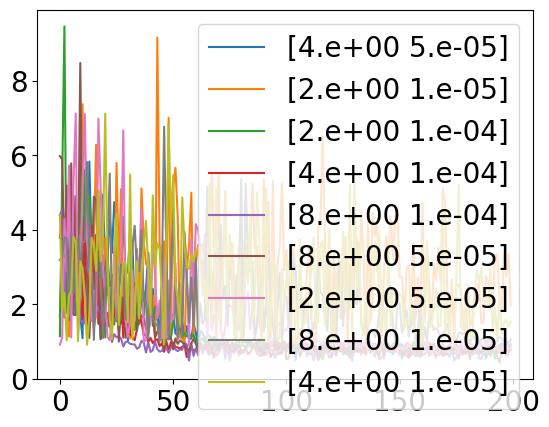

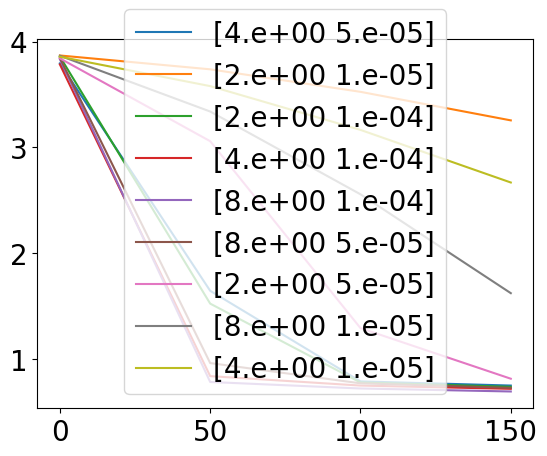

In [18]:
fig, ax = plt.subplots()
for i in range(len(all_train_loss)):
    ax.plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

fig, ax = plt.subplots()
for i in range(len(all_val_loss)):
    ax.plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

In [19]:
best_overall_params_load = joblib.load("best_overall_params.joblib")

batch_size = 4
test_size = 0.2
max_steps = 200
points = 80
lora_rank = best_overall_params_load['lora_rank']
lora_alpha = 2*lora_rank
learning_rate = best_overall_params_load['learning_rate']

ctx_lengths = [128, 512, 768]

In [21]:
for ctx_length in ctx_lengths:
    max_ctx_length = ctx_length

    # Load the model and tokenizer
    model, tokenizer = load_qwen()

    # Process the data into sequences of text
    train_texts, val_texts, test_texts = load_and_preprocess("lotka_volterra_data.h5", test_size=test_size)


    # Defines the maximum context length for the model
    train_input_ids = process_sequences(
        train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
    )
    val_input_ids = process_sequences(
        val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
    )
    test_texts_all, test_input_ids_some = process_data(
        test_texts, tokenizer, points=points
    )

    # Create data loaders
    train_dataset = TensorDataset(train_input_ids)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(val_input_ids)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_input_ids_some)
    test_loader = DataLoader(test_dataset, shuffle=False)

    # Dictionary to store results
    grid_results = {}

    print(f"\n{'='*50}")
    print(f"Training with max_ctx_length={max_ctx_length}")
    print(f"{'='*50}\n")

    # Actually apply LoRA to the model:
    for layer in model.model.layers:
        layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank, alpha = lora_alpha)
        layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank, alpha = lora_alpha)
    # ^These are the parts that will actually be trained!

    # Freeze all layers except the LoRA layers
    for name, param in model.named_parameters():
        if "A" in name or "B" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Create optimizer with current learning rate
    optimizer = torch.optim.Adam(
        (p for p in model.parameters() if p.requires_grad), 
        lr=learning_rate, 
    )

    # Prepare with accelerator
    # Use mixed precision training as it is faster and consumes less memory
    accelerator = Accelerator()
    model, optimizer, train_loader_local, val_loader_local, test_loader_local = accelerator.prepare(
        model, optimizer, train_loader, val_loader, test_loader
    )

    # Train the model (shortened training for grid search)
    steps = 0
    train_losses = []
    val_losses = []
    early_stop_steps = min(max_steps, 500)  # Reduce training for grid search

    while steps < early_stop_steps:
        progress_bar = tqdm(train_loader_local, desc=f"Steps {steps}")
        for (batch,) in progress_bar:
            model.train()
            optimizer.zero_grad()
            outputs = model(batch, labels=batch)
            loss = outputs.loss
            train_losses.append([loss.item(), steps])
            accelerator.backward(loss)
            optimizer.step()
            
            if (steps % 50) == 0:
                avg_loss = evaluate_model(model, val_loader_local, steps)
                val_losses.append([avg_loss, steps])
                model.train()
                
            steps += 1
            progress_bar.set_postfix(loss=loss.item())
            
            if steps >= early_stop_steps:
                break

    # Final evaluation
    final_val_loss = evaluate_model(model, val_loader_local, steps)

    # Calculate the FLOPs
    model_flops = Flopper(sequence_length = max_ctx_length, model=model, num_steps_training=max_steps, batch_size = batch_size, use_lora=True, lora_rank=lora_rank)
    flops = model_flops.compute_flops()
    print(f"FLOPs: {model_flops}")

    # Store results
    grid_results[(max_ctx_length)] = {
        "final_val_loss": final_val_loss,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "flops": flops
    }

    # Save results
    joblib.dump(grid_results, f"../results/grid_results_{max_ctx_length}.joblib")


    model.eval()
    with torch.no_grad():    
        for (batch,) in tqdm(test_loader_local):
            outputs = model.generate(batch, attention_mask = torch.ones_like(batch), max_new_tokens=max_ctx_length*2)
            prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
            prediction_decoded = decoding(prediction)
            break
            

    test_decoded = decoding(test_texts_all[0])

    colours = ['#7b3294', '#c2a5cf', '#a6dba0', '#008837']
    _, _, time = get_dataset()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, prediction_decoded[0], label='Prey (predicted)', linestyle="--", zorder=100, color=colours[0], linewidth=2)
    ax.plot(time, prediction_decoded[1], label='Predator (predicted)', linestyle="--", zorder=100, color=colours[3], linewidth=2)
    ax.plot(time, test_decoded[0], label='Prey (true)', color=colours[1], linewidth=2)
    ax.plot(time, test_decoded[1], label='Predator (true)', color=colours[2], linewidth=2)
    ax.axvline(time[79], color='black', linestyle='--', label='Prediction start')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.legend(fontsize=15, ncol=5, bbox_to_anchor=(0.5, 1.1), loc='center')
    plt.savefig(f'../plots/{max_ctx_length}_inspection.png')
    plt.show()

    # Clean up
    del model
    del tokenizer
    del optimizer
    del train_loader_local
    del val_loader_local
    del test_loader_local
    del accelerator
    del train_losses
    del val_losses
    torch.cuda.empty_cache()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



Training with max_ctx_length=128



Steps 0:   0%|          | 0/3806 [00:06<?, ?it/s]


KeyboardInterrupt: 

['../results/grid_results_768.joblib', '../results/grid_results_128.joblib', '../results/grid_results_512.joblib']
Key: (8, 0.0001):  0.6650285238027572
Key: 128:  0.8882208197116852
Key: 512:  0.6691922636826834

Best validation loss: 0.6650285238027572
Best file: (8, 0.0001)


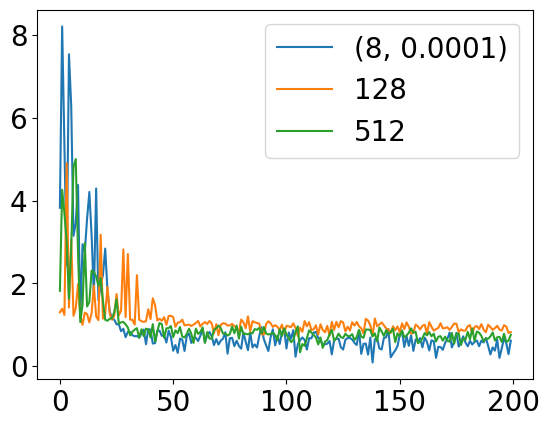

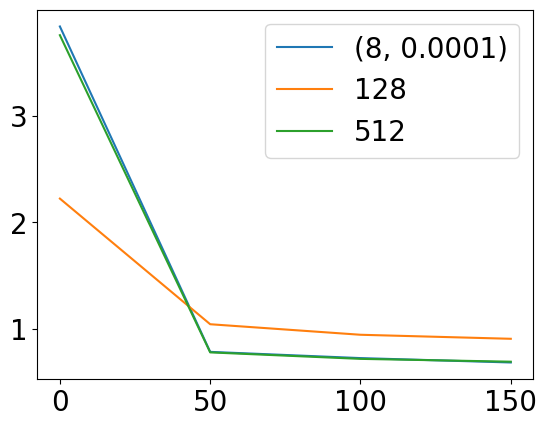

In [22]:
best_val_loss = 1000
best_params = None

all_train_loss = []
all_val_loss = []
all_keys = []

best_val_loss = 1000
best_file = None

# Pattern to match files of the form grid_results_NUMBER.joblib
pattern = r'grid_results_\d+\.joblib'

# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern (just one number after grid_results_)
result_files = [file for file in result_files if re.search(pattern, file)]

print(result_files)

# Display the content of each file
for file_path in result_files:
    # Load the joblib file
    result = joblib.load(file_path)
    
    key = next(iter(result.keys()))
    print(f"Key: {key}: ", result[key]['final_val_loss'])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(result[key]['val_losses'])
    all_keys.append(key)
    
    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_val_loss:
        best_val_loss = result[key]['final_val_loss']
        best_file = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_val_loss}")
print(f"Best file: {best_file}")
print(f"{'='*50}")

best_overall_params['max_ctx_length'] = best_file

all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)

fig, ax = plt.subplots()
for i in range(len(all_train_loss)):
    ax.plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

fig, ax = plt.subplots()
for i in range(len(all_val_loss)):
    ax.plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

In [23]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [27]:
best_overall_params_load = joblib.load("best_overall_params.joblib")

lora_rank = best_overall_params_load['lora_rank']
lora_alpha = 2*lora_rank
batch_size = 4
learning_rate = best_overall_params_load['learning_rate']
test_size = 0.2
max_steps = 200
max_ctx_length = 768#best_overall_params_load['max_ctx_length']
points = 80

schedulers = ['StepLR', 'CosineAnnealingLR', 'CosineScheduleWithWarmup']

In [29]:
for schedule_choice in schedulers:
    if schedule_choice == 'StepLR':
        step_size = 100
        gamma = 0.1
    elif schedule_choice == 'CosineAnnealingLR':
        T_max = max_steps
    elif schedule_choice == 'CosineScheduleWithWarmup':
        warmup_steps = int(0.075*max_steps)
        num_training_steps = max_steps

    # Load the model and tokenizer
    model, tokenizer = load_qwen()

    # Process the data into sequences of text
    train_texts, val_texts, test_texts = load_and_preprocess("lotka_volterra_data.h5", test_size=test_size)


    # Defines the maximum context length for the model
    train_input_ids = process_sequences(
        train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
    )
    val_input_ids = process_sequences(
        val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
    )
    test_texts_all, test_input_ids_some = process_data(
        test_texts, tokenizer, points=points
    )

    # Create data loaders

    train_dataset = TensorDataset(train_input_ids)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(val_input_ids)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_input_ids_some)
    test_loader = DataLoader(test_dataset, shuffle=False)

    # Dictionary to store results
    grid_results = {}

    print(f"\n{'='*50}")
    print(f"Training with scheduler={schedule_choice}")
    print(f"{'='*50}\n")

    # Actually apply LoRA to the model:
    for layer in model.model.layers:
        layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank, alpha = lora_alpha)
        layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank, alpha = lora_alpha)
    # ^These are the parts that will actually be trained!

    for name, param in model.named_parameters():
        if "A" in name or "B" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Freeze all layers except the LoRA layers
    for name, param in model.named_parameters():
        if "A" in name or "B" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Create optimizer with current learning rate
    optimizer = torch.optim.Adam(
        (p for p in model.parameters() if p.requires_grad), 
        lr=learning_rate, 
    )

    # Create scheduler
    if schedule_choice == 'StepLR':
        scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif schedule_choice == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=T_max)
    elif schedule_choice == 'CosineScheduleWithWarmup':
        scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

    #Prepare with accelerator
    accelerator = Accelerator()
    model, optimizer, scheduler, train_loader_local, val_loader_local, test_loader_local = accelerator.prepare(
        model, optimizer, scheduler, train_loader, val_loader, test_loader
    )

    # Train the model (shortened training for grid search)
    steps = 0
    train_losses = []
    val_losses = []
    early_stop_steps = min(max_steps, 500)  # Reduce training for grid search

    while steps < early_stop_steps:
        progress_bar = tqdm(train_loader_local, desc=f"Steps {steps}")
        for (batch,) in progress_bar:
            model.train()
            optimizer.zero_grad()
            outputs = model(batch, labels=batch)
            loss = outputs.loss
            train_losses.append([loss.item(), steps])
            accelerator.backward(loss)
            optimizer.step()
            
            if steps % 50 == 0:
                avg_loss = evaluate_model(model, val_loader_local, steps)
                val_losses.append([avg_loss, steps])
                model.train()
                
            steps += 1
            progress_bar.set_postfix(loss=loss.item())

            del loss
            del outputs
            del batch
            
            if steps >= early_stop_steps:
                break

    # Final evaluation
    final_val_loss = evaluate_model(model, val_loader_local, steps)

    # Store results
    grid_results[(schedule_choice)] = {
        "final_val_loss": final_val_loss,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }

    if schedule_choice == 'StepLR':
        grid_results[(schedule_choice)]["step_size"] = step_size
        grid_results[(schedule_choice)]["gamma"] = gamma
    elif schedule_choice == 'CosineAnnealingLR':
        grid_results[(schedule_choice)]["T_max"] = T_max
    elif schedule_choice == 'CosineScheduleWithWarmup':
        grid_results[(schedule_choice)]["warmup_steps"] = warmup_steps
        grid_results[(schedule_choice)]["num_training_steps"] = num_training_steps

    # Calculate the FLOPs
    model_flops = Flopper(sequence_length = max_ctx_length, model=model, num_steps_training=max_steps, batch_size = batch_size, use_lora=True, lora_rank=lora_rank)
    flops = model_flops.compute_flops()
    print(f"FLOPs: {flops}")

    grid_results[(schedule_choice)]={
        "flops": flops
    }

    joblib.dump(grid_results, f"../results/grid_results_{schedule_choice}.joblib")

    # Test the model
    model.eval()
    with torch.no_grad():    
        for (batch,) in tqdm(test_loader_local):
            outputs = model.generate(batch, attention_mask = torch.ones_like(batch), max_new_tokens=max_ctx_length*2)
            prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
            prediction_decoded = decoding(prediction)
            break

    test_decoded = decoding(test_texts_all[0])

    colours = ['#7b3294', '#c2a5cf', '#a6dba0', '#008837']
    _, _, time = get_dataset()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, prediction_decoded[0], label='Prey (predicted)', linestyle="--", zorder=100, color=colours[0], linewidth=2)
    ax.plot(time, prediction_decoded[1], label='Predator (predicted)', linestyle="--", zorder=100, color=colours[3], linewidth=2)
    ax.plot(time, test_decoded[0], label='Prey (true)', color=colours[1], linewidth=2)
    ax.plot(time, test_decoded[1], label='Predator (true)', color=colours[2], linewidth=2)
    ax.axvline(time[79], color='black', linestyle='--', label='Prediction start')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.legend(fontsize=15, ncol=5, bbox_to_anchor=(0.5, 1.1), loc='center')
    plt.savefig(f'../plots/{schedule_choice}_inspection.png')
    plt.show()

    # Clean up
    del model
    del tokenizer
    del optimizer
    del train_loader_local
    del val_loader_local
    del test_loader_local
    del accelerator
    del train_losses
    del val_losses
    torch.cuda.empty_cache()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



Training with scheduler=StepLR



Steps 0:   0%|          | 0/800 [00:05<?, ?it/s]


KeyboardInterrupt: 

['../results/grid_results_StepLR.joblib', '../results/grid_results_CosineScheduleWithWarmup.joblib', '../results/grid_results_CosineAnnealingLR.joblib']
Key: StepLR:  0.6637925094366074
Key: CosineScheduleWithWarmup:  3.8823856496810913
Key: CosineAnnealingLR:  0.6538862562179566

Best validation loss: 0.6538862562179566
Best file: CosineAnnealingLR


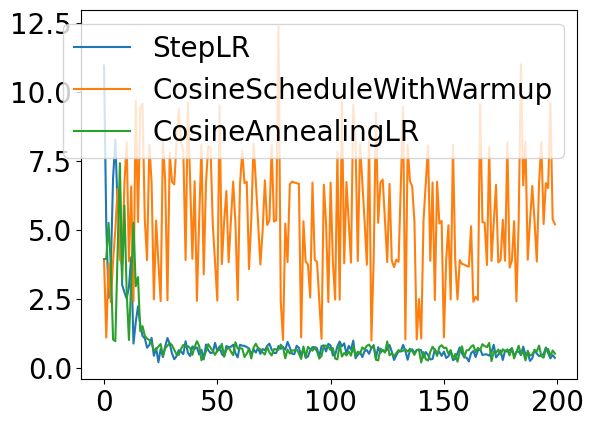

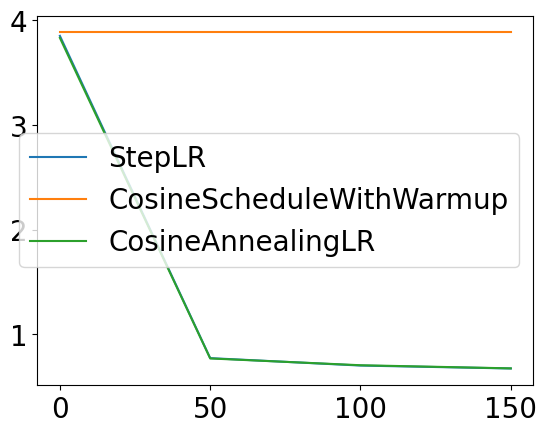

In [30]:
best_val_loss = 1000
best_params = None

all_train_loss = []
all_val_loss = []
all_keys = []

best_val_loss = 1000
best_file = None

# Pattern to match files of the form grid_results_WORDS.joblib
pattern = r'grid_results_[a-zA-Z]+\.joblib'

# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern (just one number after grid_results_)
result_files = [file for file in result_files if re.search(pattern, file)]

print(result_files)

# Display the content of each file
for file_path in result_files:
    # Load the joblib file
    result = joblib.load(file_path)
    
    key = next(iter(result.keys()))
    print(f"Key: {key}: ", result[key]['final_val_loss'])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(result[key]['val_losses'])
    all_keys.append(key)
    
    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_val_loss:
        best_val_loss = result[key]['final_val_loss']
        best_file = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_val_loss}")
print(f"Best file: {best_file}")
print(f"{'='*50}")

best_overall_params['scheduler_choice'] = best_file

all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)

fig, ax = plt.subplots()
for i in range(len(all_train_loss)):
    ax.plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

fig, ax = plt.subplots()
for i in range(len(all_val_loss)):
    ax.plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

In [ ]:
joblib.dump(best_overall_params, "best_overall_params.joblib")